In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [2]:
df = pd.read_csv("./tips.csv")
df['size'] = df['size'].astype('float')

In [3]:
df = pd.get_dummies(df)
df.head(3)

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2.0,1,0,1,0,0,0,1,0,1,0
1,10.34,1.66,3.0,0,1,1,0,0,0,1,0,1,0
2,21.01,3.50,3.0,0,1,1,0,0,0,1,0,1,0


In [4]:
df_test = df.sample(frac=0.2,replace=False,random_state=0).copy()

In [5]:
df_train = df.drop(df_test.index).copy()

In [6]:
features_train = df_train.drop('tip',axis=1)
features_test = df_test.drop('tip',axis=1)

In [7]:
target_train = df_train.tip
target_test = df_test.tip

In [8]:
grid = {'max_depth': np.arange(1,26)}

In [9]:
rtree = DecisionTreeRegressor()

In [10]:
rtreeCV = GridSearchCV(rtree,param_grid=grid,return_train_score=True)

In [11]:
rtreeCV.fit(features_train,target_train)

C:\Users\rileyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
print()
print('optimal depth= ', rtreeCV.best_params_, 'validation R2= ', rtreeCV.best_score_.round(3))


optimal depth=  {'max_depth': 2} validation R2=  0.265


In [13]:
rtree_optimal = rtreeCV.best_estimator_
target_predicted = rtree_optimal.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.749


In [14]:
rtree = DecisionTreeRegressor(max_depth=2)
rtree.fit(features_train,target_train)
target_predicted = rtree_optimal.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.749


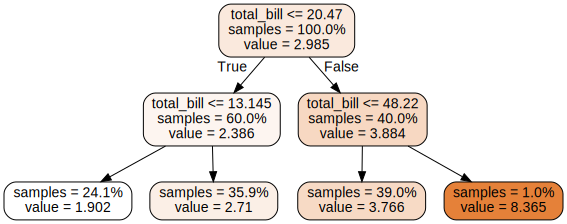

In [15]:
dot_data = export_graphviz(rtree,
                          out_file=None,
                          feature_names=features_test.columns,
                          proportion=True,
                          impurity=False,
                          filled=True,
                          rounded=True,
                          )
graph = graphviz.Source(dot_data)
graph

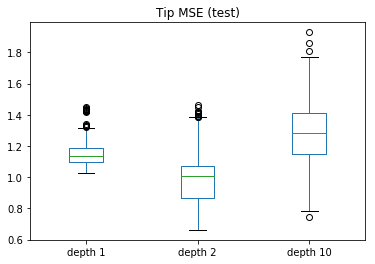

In [16]:
N = 1000
depth = [1,2,10]
errors = pd.DataFrame(index=range(1000),columns=['depth 1', 'depth 2', 'depth 10'])

for i in range(N):
    df_train_bootstrapped= df_train.sample(frac=1,replace=True).copy()
    features_bootstrapped = df_train_bootstrapped.drop('tip',axis=1)
    target_bootstrapped = df_train_bootstrapped.tip
    for j in range(3):
        rtree = DecisionTreeRegressor(max_depth=depth[j])
        rtree.fit(features_bootstrapped, target_bootstrapped)
        target_predicted = rtree.predict(features_test)
        errors.iloc[i, j] = np.sqrt(mean_squared_error(target_test,target_predicted))
        
errors.plot.box(title='Tip MSE (test)')

In [17]:
rtree = DecisionTreeRegressor(max_depth=10)

n_records = target_test.shape[0]
n_trees = 1000
target_forest = pd.DataFrame(index=range(n_records),columns=range(n_trees))

for k in range(n_trees):
    df_train_bootstrapped = df_train.sample(frac=1.0,replace=True).copy()
    features_bootstrapped = df_train_bootstrapped.drop('tip',axis=1)
    target_bootstrapped = df_train_bootstrapped.tip
    rtree.fit(features_bootstrapped, target_bootstrapped)
    target_forest.iloc[:,k] = rtree.predict(features_test)
    
target_predicted = target_forest.mean(axis=1)

RMSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE = ', RMSE_test.round(3))

test MSE =  0.882


In [18]:
rtree = DecisionTreeRegressor(max_depth=10)
bag = BaggingRegressor(rtree,n_estimators=1000,n_jobs=-1)
bag.fit(features_train,target_train)
target_predict = bag.predict(features_test)

RMSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE=', RMSE_test.round(3))

test MSE= 0.882


In [36]:
grid = {'n_estimators':np.arange(10,200)}

rf = RandomForestRegressor()
rfCV = GridSearchCV(rf,param_grid = grid, return_train_score=True,n_jobs=-1)
rfCV.fit(features_train,target_train)

print()
print("optimal number of trees = ", rfCV.best_params_, "validation R2 = ", rfCV.best_score_.round(3))

C:\Users\rileyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



optimal number of trees =  {'n_estimators': 17} validation R2 =  0.285


In [ ]:
performance = pd.DataFrame()
performance['n_estimators'] = grid['n_estimators']
performance['train R2'] = rfCV.cv_results_['mean_train_score']
performance['test R2'] = rfCV.cv_results_['mean_test_score']

ax1 = performance.plot.line(x="tree", y="train R2")
performance.plot.line(x='tree',y='test R2',ax=ax1)

In [31]:
rf = RandomForestRegressor(n_estimators=2000,n_jobs=-1,max_depth=2,oob_score=True)
rf.fit(features_train,target_train)
target_predicted = rf.predict(features_test)
MSE_test = np.sqrt(mean_squared_error(target_test,target_predicted))
print('test MSE: ', MSE_test.round(3))

test MSE:  0.871


In [32]:
rf.score(features_test,target_test).round(3)

0.622

In [33]:
rf.oob_score_.round(3)

0.336